In [121]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import html
from itunes_app_scraper.scraper import AppStoreScraper
import concurrent.futures
import matplotlib.pyplot as plt
import numpy as np

In [122]:
#Ignore: progress bar.
def ProgressBar(progress, total):
    percent = 100 * (progress/ float(total))
    bar = '❚'*int(percent) + '-' *(100-int(percent))
    print(f"\r|{bar}| {percent: .2f}%", end = "\r")

#Defining get_data function to use multi-threading in order to obtain data faster.
def get_data(input_data, iteration, lenght):
    error_list = []
    start, end = iteration * lenght, (iteration + 1) * lenght
    out_df = input_data[start:end].copy()
    for i in range(lenght):
        try:
            data = scraper.get_app_details(input_data.iloc[iteration * lenght + i, 0], country='us', add_ratings=True, sleep=0.2)
            #Python seems to interpret scraper as a global variable, otherwise this would not run. 
            out_df.iloc[i, 3] = data['sellerName']
            out_df.iloc[i, 4] = data['formattedPrice']
            out_df.iloc[i, 5] = data['userRatingCount']
            out_df.iloc[i, 6] = data['primaryGenreName']
            out_df.iloc[i, 7] = data['averageUserRating']
            out_df.iloc[i, 8] = 20*out_df.iloc[i, 5]
        except Exception as err:
            print(f'Raised {err=}, {type(err)=}')
            error_list.append(iteration * lenght + i)
    return out_df, error_list

def scatter_log(df, x, y):
    plt.scatter(
        np.log(df[x]), df[y],
        color = 'yellow',
        marker = 'o',
        edgecolor='black',
        s = 50)
    plt.title(x + ' vs ' + y)
    plt.xlabel('log(' + x + ')')
    plt.ylabel(y)
    plt.grid(True)
    plt.show()

def scatter_linear(df, x, y):
    plt.scatter(
        df[x], df[y],
        color = 'yellow',
        marker = 'o',
        edgecolor='black',
        s = 50)
    plt.title(x + ' vs ' + y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid(True)
    plt.show()

In [123]:
#Initialize variables
app_data = []
base = 'https://giuliofrey.eu/datasources/'

In [124]:
#Obtain and parse html content.
page = requests.get(base)
soup = BeautifulSoup(page.content, "lxml")

In [125]:
#Get table and table header.
table = html.unescape(soup.find(class_ = 'dataframe'))
header = [head.text for head in soup.find('thead').find_all('th')]
header

['app_id', 'rank', 'name']

In [126]:
#Keys for dataset - we want to store all the collected data in a list of dictionaries.
#List of dictionaries can easily be converted to pandas dataframe, after we collected all data.
keys = [
    header[0], #app_id
    header[1], #rank
    header[2], #name
    'developer',
    'price',
    'num_reviews',
    'genre_prim', #primary genre
    'avg_rating',
    'num_downloads'
    ]

In [127]:
#Loop over all table rows, add row values to dictionary.
for row in table.find_all('tr'):
    row_val = [cell.text for cell in row.find_all('td')]
    temp = dict.fromkeys(keys, [])
    for h, c in zip(header, row_val): #h refers to header value, c to cell value
        temp[h] = c
    app_data.append(temp)

In [128]:
#Drop the first element, which is empty.
app_data.pop(0)

{'app_id': [],
 'rank': [],
 'name': [],
 'developer': [],
 'price': [],
 'num_reviews': [],
 'genre_prim': [],
 'avg_rating': [],
 'num_downloads': []}

In [129]:
initial_df = pd.DataFrame(app_data)

In [130]:
#Speed of download depends on network quality.
scraper = AppStoreScraper()
df = pd.DataFrame(columns = keys)
num_workers = 50
num_executions = 50
error_list = []

with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [executor.submit(get_data, input_data = initial_df, iteration = c, lenght = 10) for c in range(num_executions)]
    for future in concurrent.futures.as_completed(futures):
        #print(concurrent.futures.as_completed(futures))
        new_data, errors = future.result()
        df = pd.concat([df, new_data], axis = 0)
        error_list += errors

df = df.sort_index()
df 
error_list

Raised err=AppStoreException('No app found with ID 1222902155'), type(err)=<class 'itunes_app_scraper.util.AppStoreException'>


[410]

In [131]:
#Define a function to identify rows with particular cell values or sub-strings.
def lookup(val, *args, substring=None):
    if val == [] or pd.isna(val):
        return True
    if any(arg == val for arg in args):
        return True
    if substring and isinstance(val, str) and substring in val:
        return True
    return False

In [132]:
#Check for rows with empty values and remove them from dataframe (possibly those where AppStoreScraper could not get the data but without running into an exception)
empty = df[df.map(lambda x: lookup(x)).any(axis=1)]
index = empty.index
df_cleaned = df.drop(index)
empty

,app_id,rank,name,developer,price,num_reviews,genre_prim,avg_rating,num_downloads
410,1222902155,411,Flight Board Pro,[],[],[],[],[],[]


In [133]:
#Perform data cleaning

#Note: some apps are free now. We set their price to 0.00
df_cleaned.loc[df_cleaned.map(lambda x: lookup(x, 'Free')).any(axis=1), 'price'] = '0.00'

#Removing special characters
special_chars = '®″▻™$'
pattern = f'[{special_chars}]'
df_cleaned[['price', 'name', 'developer']] = df_cleaned[['price', 'name', 'developer']].apply(lambda x: x.str.replace(pattern, '', regex=True))

#Let pandas infer datatypes, then manually convert datatypes into correct format.
df_cleaned = df_cleaned.apply(pd.to_numeric, errors = 'ignore').convert_dtypes()
df_cleaned['app_id'] = df_cleaned['app_id'].astype('string')
df_cleaned['num_downloads'] = df_cleaned['num_downloads'].astype('float64')
df_cleaned['price'] = df_cleaned['price'].astype('float64')
df_cleaned['avg_rating'] = df_cleaned['avg_rating'].astype('float64')
df_cleaned['num_reviews'] = df_cleaned['num_reviews'].astype('int64')
df_cleaned['rank'] = df_cleaned['rank'].astype('int64')

df_cleaned.dtypes

app_id           string[python]
rank                      int64
name             string[python]
developer        string[python]
price                   float64
num_reviews               int64
genre_prim       string[python]
avg_rating              float64
num_downloads           float64
dtype: object

In [134]:
#Get list of unique categories and counts
genres = df_cleaned['genre_prim'].explode().str.strip()
counts = genres.value_counts() 
counts

genre_prim
Games                218
Photo & Video         39
Health & Fitness      28
Utilities             20
Productivity          19
Weather               18
Education             16
Music                 15
Lifestyle             15
Reference             15
Entertainment         14
Travel                13
Navigation            13
Business              11
Medical               10
Finance                9
Social Networking      8
Food & Drink           6
Sports                 5
Shopping               5
News                   2
Name: count, dtype: Int64

In [135]:
#Create logical groupings of primary categories
mapping = {
    'Education & Reference': ['Education', 'Reference'],
    'Games': ['Games'],
    'Entertainment & Music': ['Entertainment', 'Music'],
    'Business and Productivity': ['Business', 'Productivity', 'Utilities', 'Finance'],
    'Lifestyle and Health': ['Lifestyle','Health & Fitness', 'Medical', 'Food & Drink', 'Shopping', 'Sports'],
    'Travel and Navigation': ['Travel', 'Navigation', 'Weather'],
    'Photo and Video': ['Photo & Video'],
    'News and Information': ['News'],
    'Social Networking and Communication': ['Social Networking']
    }

In [136]:
#Add column with the aggregate category of each app to the dataframe. Output the 'outside' categories.

#Iterate over all values of primary genre column, take the dictionary key (super-category) from the mapping to which the primary genre belongs to populate the agg_genre column:
df_cleaned['agg_genre'] = df_cleaned['genre_prim'].apply(lambda x: next((sup_category for sup_category, genres in mapping.items() if x in genres), 'Other'))
sup_genres = df_cleaned['agg_genre'].explode().str.strip()
counts = sup_genres.value_counts() 
outside_categories = counts[counts<10].index #Object is accessible via the index position
outside_categories

Index(['Social Networking and Communication', 'News and Information'], dtype='object', name='agg_genre')

In [137]:
#Create a dummy variable 'is_outside' equal to 1 if the app belongs to the outside category
df_cleaned['is_outside'] = df_cleaned['agg_genre'].apply(lambda x: 1 if x in outside_categories else 0)

In [138]:
#Perform final cleaning of new variables
df_cleaned['agg_genre'] = df_cleaned['agg_genre'].astype('string')
df_cleaned['is_outside'] = df_cleaned['is_outside'].astype('bool')
df_cleaned.dtypes

app_id           string[python]
rank                      int64
name             string[python]
developer        string[python]
price                   float64
num_reviews               int64
genre_prim       string[python]
avg_rating              float64
num_downloads           float64
agg_genre        string[python]
is_outside                 bool
dtype: object

In [139]:
#Descriptive statistics. 
descr = df_cleaned[[col for col in df_cleaned.columns if col not in ['app_id']]].describe()
descr_formatted = descr.map(lambda x: '{:.2f}'.format(float(x))) #Formatting to have the same number of decimal places for every element.

#Convert the table to latex for the document.
print(descr_formatted.to_latex())


\begin{tabular}{llllll}
\toprule
 & rank & price & num_reviews & avg_rating & num_downloads \\
\midrule
count & 499.00 & 499.00 & 499.00 & 499.00 & 499.00 \\
mean & 250.18 & 6.14 & 13285.25 & 4.63 & 265705.01 \\
std & 144.45 & 6.61 & 41427.26 & 0.29 & 828545.25 \\
min & 1.00 & 0.00 & 1737.00 & 2.77 & 34740.00 \\
25% & 125.50 & 2.99 & 2626.00 & 4.55 & 52520.00 \\
50% & 250.00 & 4.99 & 4863.00 & 4.72 & 97260.00 \\
75% & 374.50 & 6.99 & 9671.50 & 4.82 & 193430.00 \\
max & 500.00 & 59.99 & 700598.00 & 4.95 & 14011960.00 \\
\bottomrule
\end{tabular}



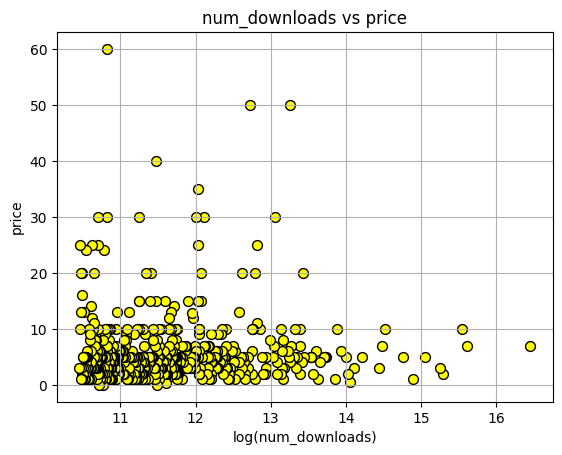

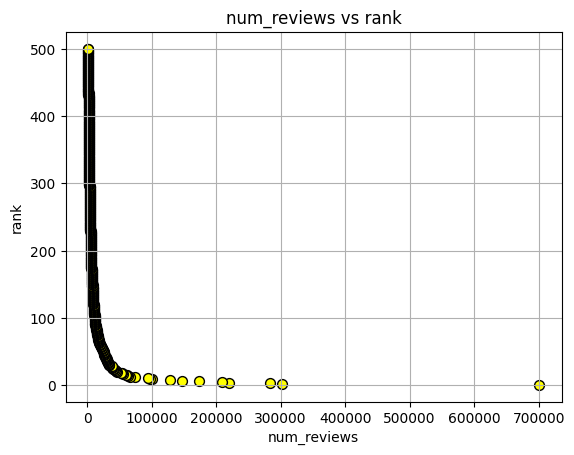

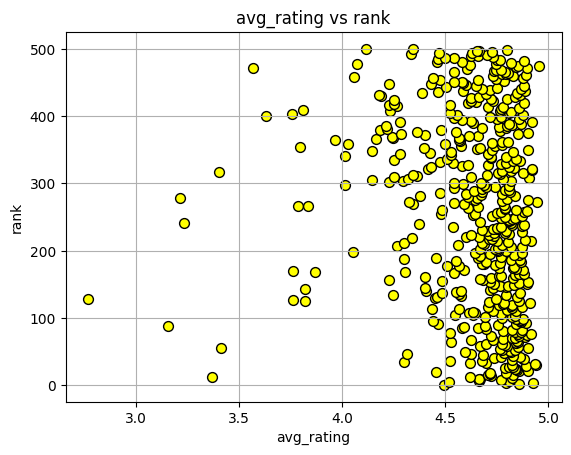

In [140]:
scatter_log(df_cleaned, 'num_downloads', 'price')
scatter_linear(df_cleaned, 'num_reviews', 'rank')
scatter_linear(df_cleaned, 'avg_rating', 'rank')

In [141]:
#Alternative demand estimation using scale parameter by Garg & Telang 2013 and re-estimation of shape parameter.

#Our estimate for the shape parameter.
scale = (df_cleaned['num_downloads'].sum()) / ((df_cleaned['rank']**(-0.944)).sum())
df_cleaned['downloads_Telang_Garg_2013_est'] = df_cleaned['rank'].apply(lambda x: scale* x**(-0.944)).round()
scale

16564434.78957133

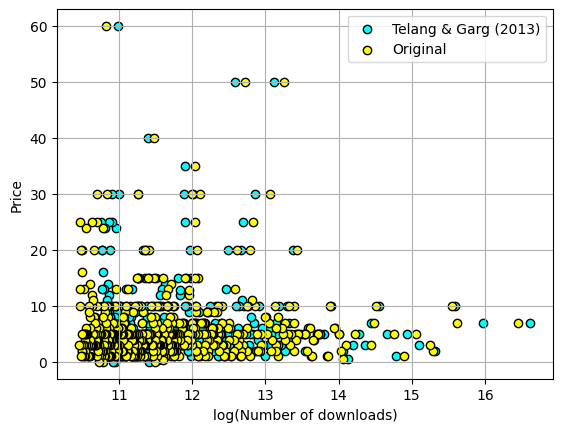

In [142]:
plt.scatter(np.log(df_cleaned['downloads_Telang_Garg_2013_est']), 
         df_cleaned['price'],
         label = 'Telang & Garg (2013)',
         color = 'cyan',
         edgecolors='black',
         marker = 'o')
plt.scatter(np.log(df_cleaned['num_downloads']), 
         df_cleaned['price'],
         label = 'Original',
         color = 'yellow',
         edgecolors='black',
         marker = 'o')
plt.xlabel('log(Number of downloads)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [143]:
#Export dataframe to CSV
df_cleaned.to_csv('dataset.csv',encoding = 'utf-8', index = False)
